# Metric Learning

In this practical, we will calculate 2-dimensional embeddings (so that we can easily visualise them) using different approaches: a classification network, a siamese network, and a triplet network. We will use FashionMNIST.

First some preliminary stuff. Apart from typical imports, we define also two functions that will help us later on to generate embeddings for all our data and to plot them in a 2D scatter plot.

In [1]:
import os
import random

import torch
from torch.optim import lr_scheduler
import torch.optim as optim

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from PIL import Image

fashion_mnist_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(fashion_mnist_classes)


def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels


## Import data

Import the FashionMNIST data and define datasets and data loaders.

In [2]:
mean, std = 0.28604059698879553, 0.35302424451492237

train_dataset = FashionMNIST('data', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = FashionMNIST('data', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

In [4]:
# Set up data loaders
batch_size = 256
kwargs = {'num_workers': 2, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

## The Embedding Network

To do the embedding always in the same manner, we will define the embedding part once, and then reuse it with different networks. The embedding we will use is a small CNN architecture, followed by a couple of FC layers that bring down the output to 2 dimensions (so that we can plot the results later).

In [5]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(1, 32, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 64, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2))

        self.fc = nn.Sequential(nn.Linear(64 * 4 * 4, 256),
                                nn.PReLU(),
                                nn.Linear(256, 256),
                                nn.PReLU(),
                                nn.Linear(256, 2)
                                )

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def get_embedding(self, x):
        return self.forward(x)

## Classification Head

The first embedding we will learn is by using a classification head. We define our classification model to use our standard embedding to 2 dimensions, then bring it up to the number of classes (10 in the case if FashionMNIST) and return the logits. We then train it using `torch.nn.CrossEntropyLoss()`.

In [6]:
class ClassificationNet(nn.Module):
    def __init__(self, embedding_net, n_classes):
        super(ClassificationNet, self).__init__()
        self.embedding_net = embedding_net
        self.n_classes = n_classes
        self.nonlinear = nn.PReLU()
        self.fc1 = nn.Linear(2, n_classes)

    def forward(self, x):
        output = self.embedding_net(x)
        output = self.nonlinear(output)
        return self.fc1(output)

    def get_embedding(self, x):
        return self.nonlinear(self.embedding_net(x))

In [7]:
def train_epoch(train_loader, model, loss_fn, optimizer):

    model.train()
    losses = []
    total_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.to(device)
        data = data.to(device)

        optimizer.zero_grad()

        outputs = model(data)

        loss = loss_fn(outputs, target)
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Evaluate on training set
        pred = outputs.max(1)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()

    total_loss /= (batch_idx + 1)
    accuracy = 100. * correct / len(train_loader.dataset)
    return total_loss, accuracy

@torch.no_grad()
def test_epoch(val_loader, model, loss_fn):

    model.eval()
    val_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(val_loader):
        target = target.to(device)
        data = data.to(device)

        outputs = model(data)

        loss = loss_fn(outputs, target)
        val_loss += loss.item()

        pred = outputs.max(1)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
        
    accuracy = 100. * correct / len(val_loader.dataset)
    return val_loss, accuracy

In [8]:
embedding_net = EmbeddingNet().to(device)
n_classes = 10
model = ClassificationNet(embedding_net, n_classes=n_classes)
model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10

In [9]:
for epoch in range(n_epochs):
    
    # Train stage
    train_loss, acc = train_epoch(train_loader, model, loss_fn, optimizer)

    scheduler.step()
    message = 'Epoch: {}/{}. Train set: Average loss: {:.4f} Accuracy: {:.2f}'.format(epoch + 1, n_epochs, train_loss, acc)

    # Validation stage
    val_loss, acc = test_epoch(test_loader, model, loss_fn)
    val_loss /= len(test_loader)

    message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f} Accuracy: {:.2f}'.format(epoch + 1, n_epochs, val_loss, acc)

    print(message)

Epoch: 1/10. Train set: Average loss: 1.3195 Accuracy: 52.90
Epoch: 1/10. Validation set: Average loss: 0.9483 Accuracy: 72.30
Epoch: 2/10. Train set: Average loss: 0.7669 Accuracy: 78.13
Epoch: 2/10. Validation set: Average loss: 0.6885 Accuracy: 83.12
Epoch: 3/10. Train set: Average loss: 0.5919 Accuracy: 84.12
Epoch: 3/10. Validation set: Average loss: 0.5748 Accuracy: 85.44
Epoch: 4/10. Train set: Average loss: 0.5015 Accuracy: 86.62
Epoch: 4/10. Validation set: Average loss: 0.5466 Accuracy: 85.77
Epoch: 5/10. Train set: Average loss: 0.4413 Accuracy: 87.62
Epoch: 5/10. Validation set: Average loss: 0.5449 Accuracy: 85.59
Epoch: 6/10. Train set: Average loss: 0.4052 Accuracy: 88.61
Epoch: 6/10. Validation set: Average loss: 0.4971 Accuracy: 87.38
Epoch: 7/10. Train set: Average loss: 0.3645 Accuracy: 89.56
Epoch: 7/10. Validation set: Average loss: 0.4828 Accuracy: 87.04
Epoch: 8/10. Train set: Average loss: 0.3315 Accuracy: 90.40
Epoch: 8/10. Validation set: Average loss: 0.4816 

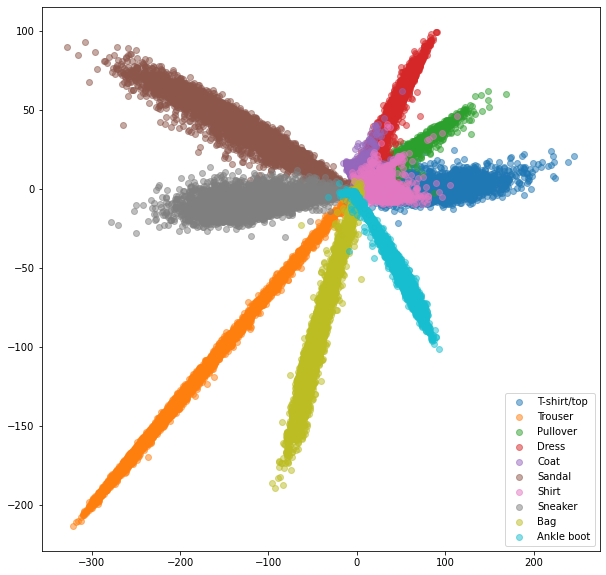

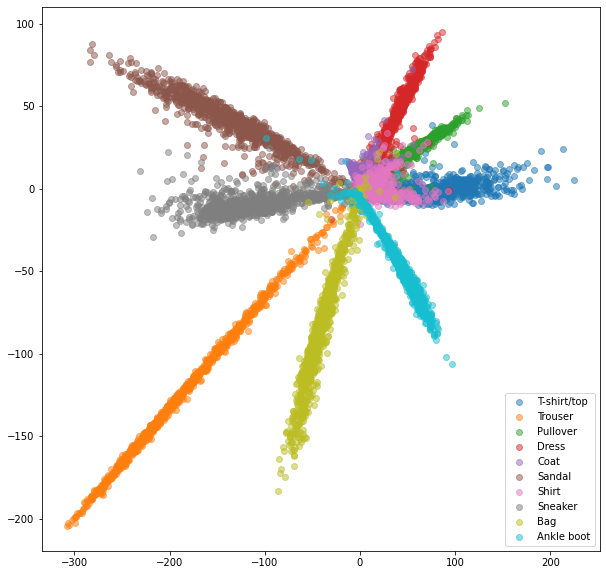

In [10]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

## Siamese Head

We will repeat the process with a siamese network, but in order to do that we need first to create a different dataset, that creates positive and negative pairs from the original dataset. The pairs will be generated on the fly, randomly, while training. While testing, we will maintain the same pairs always so that comparisons would make sense.

Note that here we just aim to create valid pairs, we do not do any mining (we do not care if they are easy, semi-hard or hard).

In [11]:
class SiameseDataset(Dataset):
    """
    Train: For each sample creates randomly a positive or a negative pair
    Test: Creates fixed pairs for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        self.labels = self.mnist_dataset.targets
        self.data = self.mnist_dataset.data
        self.labels_set = set(self.labels.numpy())
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}
            
        if not self.train:
            # generate fixed pairs for testing once at initialisation
            random_state = np.random.RandomState(29) # Fix random seed for testing

            positive_pairs = [[i,
                               random_state.choice(self.label_to_indices[self.labels[i].item()]),
                               1]
                              for i in range(0, len(self.data), 2)]

            negative_pairs = [[i,
                               random_state.choice(self.label_to_indices[
                                                       np.random.choice(
                                                           list(self.labels_set - set([self.labels[i].item()]))
                                                       )
                                                   ]),
                               0]
                              for i in range(1, len(self.data), 2)]
            self.test_pairs = positive_pairs + negative_pairs

    def __getitem__(self, index):
        if self.train:
            # Generate a positive or negative pair on the fly
            target = np.random.randint(0, 2) # randomly select positive or negative
            img1, label1 = self.data[index], self.labels[index].item()
            if target == 1: # Generate a POSITIVE pair
                siamese_index = index
                while siamese_index == index: # Make sure we do not use ourself as the positive pair
                    siamese_index = np.random.choice(self.label_to_indices[label1])
            else: # Generate a NEGATIVE pair
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                siamese_index = np.random.choice(self.label_to_indices[siamese_label])
            img2 = self.data[siamese_index]
        else:
            # Just retrieve the pair from the saved test pairs we generated at init
            img1 = self.data[self.test_pairs[index][0]]
            img2 = self.data[self.test_pairs[index][1]]
            target = self.test_pairs[index][2]

        # Get a PIL image to pass through thransform
        img1 = Image.fromarray(img1.numpy(), mode='L')
        img2 = Image.fromarray(img2.numpy(), mode='L')
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return img1, img2, target

        
    def __len__(self):
        return len(self.mnist_dataset)

Now we are ready to define our siamese net which just takes in one training sample (which now comprises a pair of images) and embeds them using our embedding function. It returns the two embeddings.

In [12]:
class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.embedding_net(x)

The next thing to do is to define our loss function for the case of the siamese. In this case, we need a function that takes as input TWO vectors and one target that indicates if they are supposed to be a positive pair, or a negative pair, and implements the function:

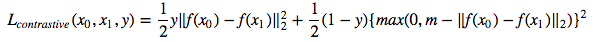

In [13]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        # losses = 0.5 * (target.float() * distances + (1 - target).float() * max(0, self.margin - (distances + self.eps).sqrt()).pow(2)) equivalent to
        losses = 0.5 * (target.float() * distances + (1 - target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()

We will also redefine the training and validation loops, as now the data loader gives us 2 samples and the loss function expects 2 samples.

In [14]:
def train_epoch_siamese(train_loader, model, loss_fn, optimizer):

    model.train()
    losses = []
    total_loss = 0
    correct = 0

    for batch_idx, (data1, data2, target) in enumerate(train_loader):
        target = target.to(device)
        data1 = data1.to(device)
        data2 = data2.to(device)

        optimizer.zero_grad()

        output1, output2 = model(data1, data2)

        # The loss is the only thing we can report here
        loss = loss_fn(output1, output2, target)
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    total_loss /= (batch_idx + 1)
    return total_loss

@torch.no_grad()
def test_epoch_siamese(val_loader, model, loss_fn):

    model.eval()
    val_loss = 0
    correct = 0

    for batch_idx, (data1, data2, target) in enumerate(val_loader):
        target = target.to(device)
        data1 = data1.to(device)
        data2 = data2.to(device)

        output1, output2 = model(data1, data2)

        loss = loss_fn(output1, output2, target)
        val_loss += loss.item()
        
    return val_loss

In [15]:
siamese_train_dataset = SiameseDataset(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseDataset(test_dataset)

batch_size = 128
kwargs = {'num_workers': 2, 'pin_memory': True}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
model.to(device)
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10

In [16]:
for epoch in range(n_epochs):

        # Train stage
        train_loss = train_epoch_siamese(siamese_train_loader, model, loss_fn, optimizer)
        scheduler.step()

        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)

        # Validation stage
        val_loss = test_epoch_siamese(siamese_test_loader, model, loss_fn)
        val_loss /= len(siamese_test_loader)

        message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, val_loss)

        print(message)

Epoch: 1/10. Train set: Average loss: 0.0506
Epoch: 1/10. Validation set: Average loss: 0.0405
Epoch: 2/10. Train set: Average loss: 0.0397
Epoch: 2/10. Validation set: Average loss: 0.0376
Epoch: 3/10. Train set: Average loss: 0.0347
Epoch: 3/10. Validation set: Average loss: 0.0379
Epoch: 4/10. Train set: Average loss: 0.0322
Epoch: 4/10. Validation set: Average loss: 0.0333
Epoch: 5/10. Train set: Average loss: 0.0290
Epoch: 5/10. Validation set: Average loss: 0.0319
Epoch: 6/10. Train set: Average loss: 0.0275
Epoch: 6/10. Validation set: Average loss: 0.0300
Epoch: 7/10. Train set: Average loss: 0.0257
Epoch: 7/10. Validation set: Average loss: 0.0309
Epoch: 8/10. Train set: Average loss: 0.0255
Epoch: 8/10. Validation set: Average loss: 0.0302
Epoch: 9/10. Train set: Average loss: 0.0218
Epoch: 9/10. Validation set: Average loss: 0.0276
Epoch: 10/10. Train set: Average loss: 0.0208
Epoch: 10/10. Validation set: Average loss: 0.0272


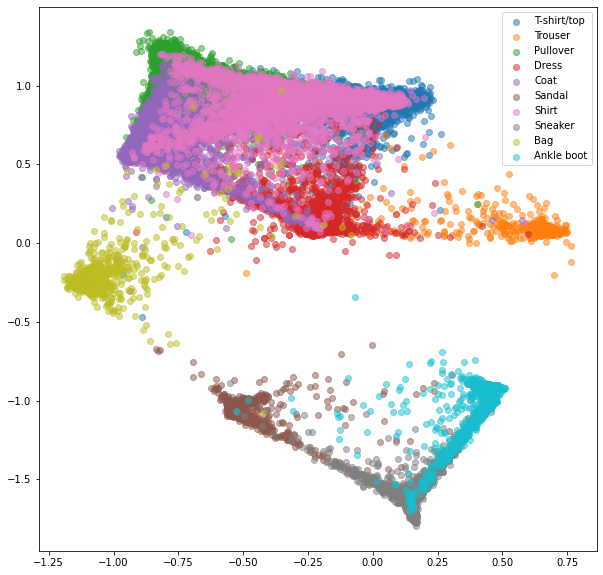

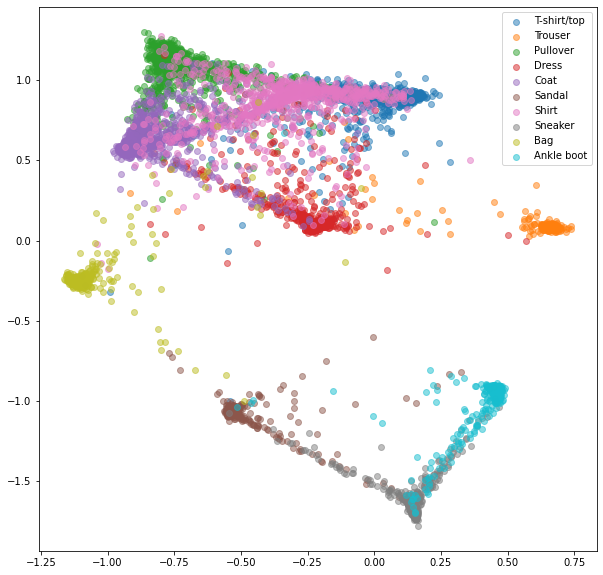

In [17]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

There are couple of problems with siamese and (triplet) networks the way we have implemented them up to this point.

- The number of possible pairs/triplets grows quadratically/cubically with the number of examples. It's infeasible to process them all
- We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with hard examples.
- Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. 

## Triplet Loss

We will now train FashionMNIST using a semi-hard Triplet Mining strategy, and visualize the embeddings. 

We will not implement any miner, loss or distance function by hand. Instead we will use [The Pytorch Metric Learning Library](https://github.com/KevinMusgrave/pytorch-metric-learning) (installed in the cell below) which implements everything we need.

Check its [docs](https://kevinmusgrave.github.io/pytorch-metric-learning/) so that you get an idea of how to use it.

In [18]:
!pip install pytorch-metric-learning faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 4.8 MB/s 
     |████████████████████████████████| 85.5 MB 123 kB/s 


In [19]:
from pytorch_metric_learning import losses, miners, distances, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

We will redefine our training and test loops to use this library. The idea is that first we embedd all the data inside our batch. Then we will ask a *Miner* to find good triplets. The list of triplets (a list of tuples with indices) will be passed on to the loss function, that will calculate the loss based on them.

In [20]:
def train(model, loss_func, mining_func, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        total_loss += loss.item()
        loss.backward()

        optimizer.step()
        if batch_idx % 20 == 0:
            print("Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(epoch, batch_idx, loss, mining_func.num_triplets))

    return total_loss / (batch_idx + 1)

def get_all_embeddings(dataset, model):
    tester = testers.BaseTester(dataloader_num_workers=2)
    return tester.get_all_embeddings(dataset, model)

def test(train_set, test_set, model, accuracy_calculator):
    model.eval()
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)

    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(test_embeddings, 
                                                train_embeddings,
                                                test_labels,
                                                train_labels,
                                                False)
    
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))


We now need to define our miner. Here we will use a `TripletMarginMiner` and cosine similarity to measure the distance between embeddings. We will also use an "accuracy" calculator. The actual metric we will be using is a *precision at 1*, which is just a fancy way to ask whether the 1st nearest neighbour of each sample is of the same class.

https://kevinmusgrave.github.io/pytorch-metric-learning/accuracy_calculation/

In [21]:
distance = distances.CosineSimilarity()
mining_func = miners.TripletMarginMiner(margin = 0.2, distance=distance, type_of_triplets="all")
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k = 1)

Define the datasets, dataloaders, and the model to use. The model we will use here is just the embedding net on its own.

In [22]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

model = EmbeddingNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_func = losses.TripletMarginLoss(margin=1., distance = distance)

Epoch 1 Iteration 0: Loss = 1.0193654298782349, Number of mined triplets = 173975
Epoch 1 Iteration 20: Loss = 1.0252223014831543, Number of mined triplets = 95469
Epoch 1 Iteration 40: Loss = 0.9753496646881104, Number of mined triplets = 80504
Epoch 1 Iteration 60: Loss = 0.9817814230918884, Number of mined triplets = 71080
Epoch 1 Iteration 80: Loss = 0.9929029941558838, Number of mined triplets = 85894
Epoch 1 Iteration 100: Loss = 0.9915958642959595, Number of mined triplets = 53816
Epoch 1 Iteration 120: Loss = 0.9725464582443237, Number of mined triplets = 71303
Epoch 1 Iteration 140: Loss = 1.0066334009170532, Number of mined triplets = 59214
Epoch 1 Iteration 160: Loss = 1.0501995086669922, Number of mined triplets = 35400
Epoch 1 Iteration 180: Loss = 1.009816288948059, Number of mined triplets = 40668
Epoch 1 Iteration 200: Loss = 1.0174568891525269, Number of mined triplets = 43214
Epoch 1 Iteration 220: Loss = 0.9476704001426697, Number of mined triplets = 37669
Epoch 1 It

100%|██████████| 313/313 [00:02<00:00, 137.67it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6486000000000001
Epoch 2 Iteration 0: Loss = 1.0419809818267822, Number of mined triplets = 50184
Epoch 2 Iteration 20: Loss = 0.9619159698486328, Number of mined triplets = 43028
Epoch 2 Iteration 40: Loss = 0.9735108613967896, Number of mined triplets = 39639
Epoch 2 Iteration 60: Loss = 0.960877001285553, Number of mined triplets = 55302
Epoch 2 Iteration 80: Loss = 0.9698153138160706, Number of mined triplets = 49912
Epoch 2 Iteration 100: Loss = 1.0847004652023315, Number of mined triplets = 35566
Epoch 2 Iteration 120: Loss = 0.9534357786178589, Number of mined triplets = 39081
Epoch 2 Iteration 140: Loss = 0.9749458432197571, Number of mined triplets = 28387
Epoch 2 Iteration 160: Loss = 0.9843441247940063, Number of mined triplets = 25344
Epoch 2 Iteration 180: Loss = 1.0104023218154907, Number of mined triplets = 42327
Epoch 2 Iteration 200: Loss = 0.9775281548500061, Number of mined triplets = 26737
Epoch 2 Iteration 220:

100%|██████████| 313/313 [00:02<00:00, 132.45it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6754
Epoch 3 Iteration 0: Loss = 0.9683132767677307, Number of mined triplets = 30396
Epoch 3 Iteration 20: Loss = 0.9520469903945923, Number of mined triplets = 22670
Epoch 3 Iteration 40: Loss = 0.9761515259742737, Number of mined triplets = 42181
Epoch 3 Iteration 60: Loss = 0.9982488751411438, Number of mined triplets = 26363
Epoch 3 Iteration 80: Loss = 0.9550715684890747, Number of mined triplets = 27158
Epoch 3 Iteration 100: Loss = 0.9656921625137329, Number of mined triplets = 28670
Epoch 3 Iteration 120: Loss = 1.0193796157836914, Number of mined triplets = 25722
Epoch 3 Iteration 140: Loss = 0.9866346716880798, Number of mined triplets = 31942
Epoch 3 Iteration 160: Loss = 1.004973292350769, Number of mined triplets = 22350
Epoch 3 Iteration 180: Loss = 0.9738550782203674, Number of mined triplets = 34983
Epoch 3 Iteration 200: Loss = 0.9722027778625488, Number of mined triplets = 31466
Epoch 3 Iteration 220: Loss = 0.97

100%|██████████| 313/313 [00:02<00:00, 136.41it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7121000000000001
Epoch 4 Iteration 0: Loss = 1.0650248527526855, Number of mined triplets = 25181
Epoch 4 Iteration 20: Loss = 0.9398786425590515, Number of mined triplets = 26685
Epoch 4 Iteration 40: Loss = 0.9729517698287964, Number of mined triplets = 28274
Epoch 4 Iteration 60: Loss = 0.9761355519294739, Number of mined triplets = 36251
Epoch 4 Iteration 80: Loss = 0.9770885705947876, Number of mined triplets = 36266
Epoch 4 Iteration 100: Loss = 0.9788529276847839, Number of mined triplets = 28216
Epoch 4 Iteration 120: Loss = 0.9627721905708313, Number of mined triplets = 33414
Epoch 4 Iteration 140: Loss = 0.9994369745254517, Number of mined triplets = 25277
Epoch 4 Iteration 160: Loss = 0.9594878554344177, Number of mined triplets = 23814
Epoch 4 Iteration 180: Loss = 0.9620019197463989, Number of mined triplets = 32549
Epoch 4 Iteration 200: Loss = 1.0226303339004517, Number of mined triplets = 30077
Epoch 4 Iteration 220

100%|██████████| 313/313 [00:02<00:00, 138.38it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7237
Epoch 5 Iteration 0: Loss = 0.9799071550369263, Number of mined triplets = 32951
Epoch 5 Iteration 20: Loss = 0.9794481992721558, Number of mined triplets = 20550
Epoch 5 Iteration 40: Loss = 1.074913501739502, Number of mined triplets = 18449
Epoch 5 Iteration 60: Loss = 0.9574692249298096, Number of mined triplets = 24200
Epoch 5 Iteration 80: Loss = 0.9717103242874146, Number of mined triplets = 27471
Epoch 5 Iteration 100: Loss = 1.170167088508606, Number of mined triplets = 39559
Epoch 5 Iteration 120: Loss = 0.9783709049224854, Number of mined triplets = 23218
Epoch 5 Iteration 140: Loss = 0.9841496348381042, Number of mined triplets = 31460
Epoch 5 Iteration 160: Loss = 0.9400075674057007, Number of mined triplets = 18890
Epoch 5 Iteration 180: Loss = 1.0828584432601929, Number of mined triplets = 27728
Epoch 5 Iteration 200: Loss = 0.9932238459587097, Number of mined triplets = 33403
Epoch 5 Iteration 220: Loss = 0.990

100%|██████████| 313/313 [00:02<00:00, 136.11it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7628
Epoch 6 Iteration 0: Loss = 0.9921398758888245, Number of mined triplets = 21741
Epoch 6 Iteration 20: Loss = 0.9426730871200562, Number of mined triplets = 20755
Epoch 6 Iteration 40: Loss = 0.9618458151817322, Number of mined triplets = 21351
Epoch 6 Iteration 60: Loss = 0.9427791237831116, Number of mined triplets = 24925
Epoch 6 Iteration 80: Loss = 0.9832749962806702, Number of mined triplets = 26711
Epoch 6 Iteration 100: Loss = 1.027144432067871, Number of mined triplets = 38954
Epoch 6 Iteration 120: Loss = 0.989477813243866, Number of mined triplets = 23895
Epoch 6 Iteration 140: Loss = 1.005077600479126, Number of mined triplets = 32968
Epoch 6 Iteration 160: Loss = 0.9616846442222595, Number of mined triplets = 39400
Epoch 6 Iteration 180: Loss = 1.0082240104675293, Number of mined triplets = 38047
Epoch 6 Iteration 200: Loss = 0.9789395332336426, Number of mined triplets = 30609
Epoch 6 Iteration 220: Loss = 0.9546

100%|██████████| 313/313 [00:02<00:00, 135.81it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7592
Epoch 7 Iteration 0: Loss = 0.9808990359306335, Number of mined triplets = 27496
Epoch 7 Iteration 20: Loss = 0.9332045912742615, Number of mined triplets = 9540
Epoch 7 Iteration 40: Loss = 1.0001360177993774, Number of mined triplets = 22840
Epoch 7 Iteration 60: Loss = 0.9453024864196777, Number of mined triplets = 18490
Epoch 7 Iteration 80: Loss = 0.9829717874526978, Number of mined triplets = 20550
Epoch 7 Iteration 100: Loss = 0.9524669051170349, Number of mined triplets = 33879
Epoch 7 Iteration 120: Loss = 1.0026265382766724, Number of mined triplets = 22674
Epoch 7 Iteration 140: Loss = 1.018715262413025, Number of mined triplets = 29053
Epoch 7 Iteration 160: Loss = 0.9621278643608093, Number of mined triplets = 37505
Epoch 7 Iteration 180: Loss = 0.9865453839302063, Number of mined triplets = 27882
Epoch 7 Iteration 200: Loss = 0.9624267816543579, Number of mined triplets = 15786
Epoch 7 Iteration 220: Loss = 0.963

100%|██████████| 313/313 [00:02<00:00, 134.21it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7845000000000001
Epoch 8 Iteration 0: Loss = 0.9476462006568909, Number of mined triplets = 27471
Epoch 8 Iteration 20: Loss = 0.9884978532791138, Number of mined triplets = 25193
Epoch 8 Iteration 40: Loss = 0.95082026720047, Number of mined triplets = 25076
Epoch 8 Iteration 60: Loss = 0.9560872912406921, Number of mined triplets = 22057
Epoch 8 Iteration 80: Loss = 0.9740901589393616, Number of mined triplets = 23170
Epoch 8 Iteration 100: Loss = 0.9418160319328308, Number of mined triplets = 45592
Epoch 8 Iteration 120: Loss = 0.9486504793167114, Number of mined triplets = 27563
Epoch 8 Iteration 140: Loss = 0.9439814686775208, Number of mined triplets = 23733
Epoch 8 Iteration 160: Loss = 0.9849475026130676, Number of mined triplets = 22310
Epoch 8 Iteration 180: Loss = 0.9647813439369202, Number of mined triplets = 21397
Epoch 8 Iteration 200: Loss = 0.9859495162963867, Number of mined triplets = 20492
Epoch 8 Iteration 220: 

100%|██████████| 313/313 [00:02<00:00, 124.89it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7884
Epoch 9 Iteration 0: Loss = 1.1537164449691772, Number of mined triplets = 28691
Epoch 9 Iteration 20: Loss = 1.0582948923110962, Number of mined triplets = 23643
Epoch 9 Iteration 40: Loss = 1.0342919826507568, Number of mined triplets = 26967
Epoch 9 Iteration 60: Loss = 0.9312277436256409, Number of mined triplets = 16291
Epoch 9 Iteration 80: Loss = 1.0542930364608765, Number of mined triplets = 23042
Epoch 9 Iteration 100: Loss = 0.9531813263893127, Number of mined triplets = 29334
Epoch 9 Iteration 120: Loss = 1.045836329460144, Number of mined triplets = 26935
Epoch 9 Iteration 140: Loss = 0.9750098586082458, Number of mined triplets = 14977
Epoch 9 Iteration 160: Loss = 0.9532157778739929, Number of mined triplets = 21648
Epoch 9 Iteration 180: Loss = 0.9598832726478577, Number of mined triplets = 20387
Epoch 9 Iteration 200: Loss = 0.9802670478820801, Number of mined triplets = 32282
Epoch 9 Iteration 220: Loss = 1.00

100%|██████████| 313/313 [00:02<00:00, 135.71it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7956000000000001
Epoch 10 Iteration 0: Loss = 0.9749796986579895, Number of mined triplets = 25423
Epoch 10 Iteration 20: Loss = 0.9277339577674866, Number of mined triplets = 19276
Epoch 10 Iteration 40: Loss = 1.0980899333953857, Number of mined triplets = 25048
Epoch 10 Iteration 60: Loss = 0.9685478210449219, Number of mined triplets = 22313
Epoch 10 Iteration 80: Loss = 0.9432745575904846, Number of mined triplets = 12675
Epoch 10 Iteration 100: Loss = 0.9387797713279724, Number of mined triplets = 21927
Epoch 10 Iteration 120: Loss = 0.9324014782905579, Number of mined triplets = 17848
Epoch 10 Iteration 140: Loss = 1.0293235778808594, Number of mined triplets = 20991
Epoch 10 Iteration 160: Loss = 0.9890977144241333, Number of mined triplets = 17624
Epoch 10 Iteration 180: Loss = 0.9788533449172974, Number of mined triplets = 36344
Epoch 10 Iteration 200: Loss = 0.9571265578269958, Number of mined triplets = 24275
Epoch 10 I

100%|██████████| 313/313 [00:02<00:00, 135.31it/s]


Computing accuracy


No handles with labels found to put in legend.


Test set accuracy (Precision@1) = 0.7974


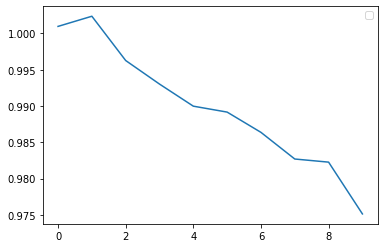

In [23]:
num_epochs = 10
loss_evolution = []

for epoch in range(1, num_epochs + 1):
    loss = train(model, loss_func, mining_func, train_loader, optimizer, epoch)
    loss_evolution.append(loss)
    test(train_dataset, test_dataset, model, accuracy_calculator)

plt.plot(loss_evolution)
plt.legend()
plt.show()

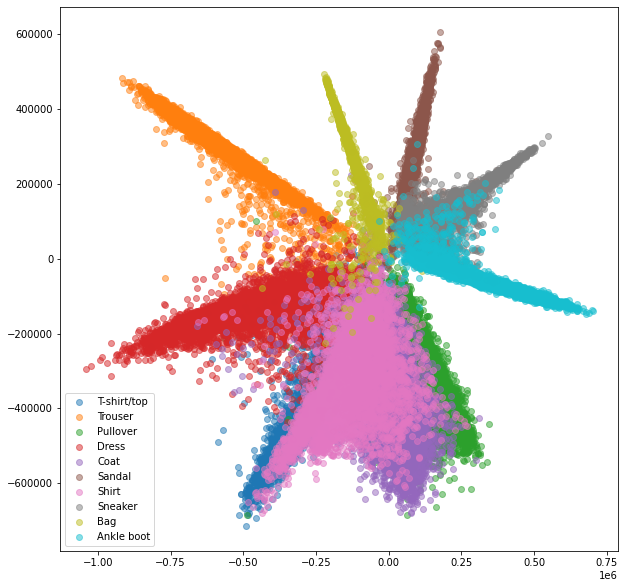

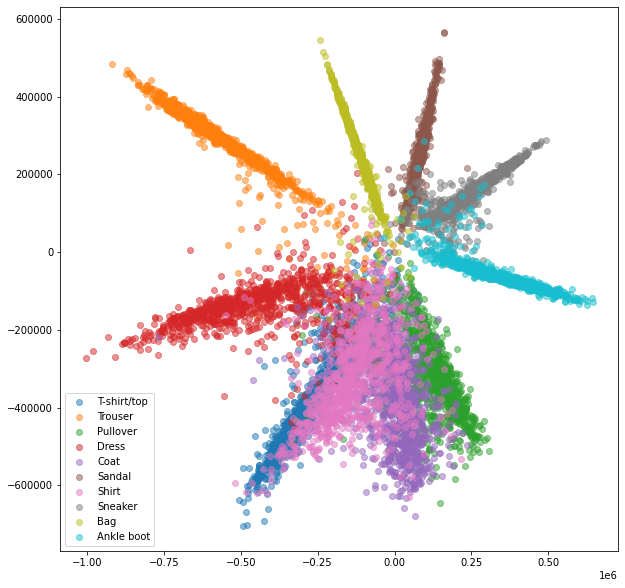

In [24]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

## Better Mining

<br>
<span style="color:blue">

**Exercise 1**: Explain the difference between semi-hard, easy and hard triplets. Try training with each type of triplets mentioned above separately and comment on the effect they have on training, using loss curves and other evidence you find necessary.
    
</span>

In [25]:
#Your Code Here


Epoch 1 Iteration 0: Loss = 0.6536156535148621, Number of mined triplets = 18772
Epoch 1 Iteration 20: Loss = 0.4631812870502472, Number of mined triplets = 88477
Epoch 1 Iteration 40: Loss = 0.35283613204956055, Number of mined triplets = 103857
Epoch 1 Iteration 60: Loss = 0.4056752920150757, Number of mined triplets = 127454
Epoch 1 Iteration 80: Loss = 0.35980430245399475, Number of mined triplets = 119766
Epoch 1 Iteration 100: Loss = 0.36573082208633423, Number of mined triplets = 139952
Epoch 1 Iteration 120: Loss = 0.41430333256721497, Number of mined triplets = 127020
Epoch 1 Iteration 140: Loss = 0.32910338044166565, Number of mined triplets = 123461
Epoch 1 Iteration 160: Loss = 0.36369115114212036, Number of mined triplets = 127418
Epoch 1 Iteration 180: Loss = 0.2382292002439499, Number of mined triplets = 125856
Epoch 1 Iteration 200: Loss = 0.3837313652038574, Number of mined triplets = 124696
Epoch 1 Iteration 220: Loss = 0.34841611981391907, Number of mined triplets = 

100%|██████████| 313/313 [00:02<00:00, 138.00it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.41500000000000004
Epoch 2 Iteration 0: Loss = 0.0922473818063736, Number of mined triplets = 140432
Epoch 2 Iteration 20: Loss = 0.05311230197548866, Number of mined triplets = 134971
Epoch 2 Iteration 40: Loss = 0.07776810228824615, Number of mined triplets = 144874
Epoch 2 Iteration 60: Loss = 0.029100263491272926, Number of mined triplets = 125860
Epoch 2 Iteration 80: Loss = 0.11393892019987106, Number of mined triplets = 135995
Epoch 2 Iteration 100: Loss = 0.0748336985707283, Number of mined triplets = 132918
Epoch 2 Iteration 120: Loss = 0.07944941520690918, Number of mined triplets = 144773
Epoch 2 Iteration 140: Loss = 0.03930503502488136, Number of mined triplets = 123551
Epoch 2 Iteration 160: Loss = 0.05320609360933304, Number of mined triplets = 142515
Epoch 2 Iteration 180: Loss = 0.043230775743722916, Number of mined triplets = 132679
Epoch 2 Iteration 200: Loss = 0.04341472312808037, Number of mined triplets = 13515

100%|██████████| 313/313 [00:02<00:00, 134.40it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.43260000000000004
Epoch 3 Iteration 0: Loss = 0.39881157875061035, Number of mined triplets = 129552
Epoch 3 Iteration 20: Loss = 0.37636303901672363, Number of mined triplets = 134427
Epoch 3 Iteration 40: Loss = 0.43441787362098694, Number of mined triplets = 136419
Epoch 3 Iteration 60: Loss = 0.23349998891353607, Number of mined triplets = 141407
Epoch 3 Iteration 80: Loss = 0.21993723511695862, Number of mined triplets = 142995
Epoch 3 Iteration 100: Loss = 0.24246935546398163, Number of mined triplets = 150123
Epoch 3 Iteration 120: Loss = 0.14280550181865692, Number of mined triplets = 144187
Epoch 3 Iteration 140: Loss = 0.2588709890842438, Number of mined triplets = 140403
Epoch 3 Iteration 160: Loss = 0.2499532550573349, Number of mined triplets = 136395
Epoch 3 Iteration 180: Loss = 0.2145846039056778, Number of mined triplets = 142248
Epoch 3 Iteration 200: Loss = 0.22154240310192108, Number of mined triplets = 143856
E

100%|██████████| 313/313 [00:02<00:00, 138.34it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.43510000000000004
Epoch 4 Iteration 0: Loss = 0.11466997861862183, Number of mined triplets = 140428
Epoch 4 Iteration 20: Loss = 0.04686824604868889, Number of mined triplets = 155994
Epoch 4 Iteration 40: Loss = 0.10653768479824066, Number of mined triplets = 140220
Epoch 4 Iteration 60: Loss = 0.08716672658920288, Number of mined triplets = 140397
Epoch 4 Iteration 80: Loss = 0.06527518481016159, Number of mined triplets = 133365
Epoch 4 Iteration 100: Loss = 0.03396983444690704, Number of mined triplets = 145382
Epoch 4 Iteration 120: Loss = 0.08260965347290039, Number of mined triplets = 143183
Epoch 4 Iteration 140: Loss = 0.028382472693920135, Number of mined triplets = 153259
Epoch 4 Iteration 160: Loss = 0.061778198927640915, Number of mined triplets = 137974
Epoch 4 Iteration 180: Loss = 0.11990907788276672, Number of mined triplets = 142873
Epoch 4 Iteration 200: Loss = 0.09145323187112808, Number of mined triplets = 137

100%|██████████| 313/313 [00:02<00:00, 137.38it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.4711
Epoch 5 Iteration 0: Loss = 0.04713021218776703, Number of mined triplets = 139679
Epoch 5 Iteration 20: Loss = 0.049831822514534, Number of mined triplets = 139021
Epoch 5 Iteration 40: Loss = 0.020109638571739197, Number of mined triplets = 134937
Epoch 5 Iteration 60: Loss = 0.012088808231055737, Number of mined triplets = 141376
Epoch 5 Iteration 80: Loss = 0.03628639504313469, Number of mined triplets = 143825
Epoch 5 Iteration 100: Loss = 0.0365404412150383, Number of mined triplets = 146439
Epoch 5 Iteration 120: Loss = 0.029415711760520935, Number of mined triplets = 134868
Epoch 5 Iteration 140: Loss = 0.020646817982196808, Number of mined triplets = 142952
Epoch 5 Iteration 160: Loss = 0.04057850316166878, Number of mined triplets = 139205
Epoch 5 Iteration 180: Loss = 0.06335613131523132, Number of mined triplets = 130777
Epoch 5 Iteration 200: Loss = 0.023805642500519753, Number of mined triplets = 151520
Epoch 5 I

100%|██████████| 313/313 [00:02<00:00, 136.55it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.4304
Epoch 6 Iteration 0: Loss = 0.029332466423511505, Number of mined triplets = 144095
Epoch 6 Iteration 20: Loss = 0.0635300800204277, Number of mined triplets = 143812
Epoch 6 Iteration 40: Loss = 0.09496907144784927, Number of mined triplets = 139410
Epoch 6 Iteration 60: Loss = 0.027979541569948196, Number of mined triplets = 139053
Epoch 6 Iteration 80: Loss = 0.035904139280319214, Number of mined triplets = 141398
Epoch 6 Iteration 100: Loss = 0.06510718166828156, Number of mined triplets = 143405
Epoch 6 Iteration 120: Loss = 0.06591130793094635, Number of mined triplets = 139833
Epoch 6 Iteration 140: Loss = 0.023471485823392868, Number of mined triplets = 141570
Epoch 6 Iteration 160: Loss = 0.04339224472641945, Number of mined triplets = 146326
Epoch 6 Iteration 180: Loss = 0.03813847899436951, Number of mined triplets = 132414
Epoch 6 Iteration 200: Loss = 0.05510236695408821, Number of mined triplets = 134753
Epoch 6 

100%|██████████| 313/313 [00:02<00:00, 135.69it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.4172
Epoch 7 Iteration 0: Loss = 0.045455384999513626, Number of mined triplets = 138198
Epoch 7 Iteration 20: Loss = 0.023332921788096428, Number of mined triplets = 140297
Epoch 7 Iteration 40: Loss = 0.019704295322299004, Number of mined triplets = 155460
Epoch 7 Iteration 60: Loss = 0.04636562988162041, Number of mined triplets = 153495
Epoch 7 Iteration 80: Loss = 0.096296027302742, Number of mined triplets = 142138
Epoch 7 Iteration 100: Loss = 0.1746405065059662, Number of mined triplets = 146003
Epoch 7 Iteration 120: Loss = 0.08972641825675964, Number of mined triplets = 143058
Epoch 7 Iteration 140: Loss = 0.12976430356502533, Number of mined triplets = 147532
Epoch 7 Iteration 160: Loss = 0.08562710881233215, Number of mined triplets = 132247
Epoch 7 Iteration 180: Loss = 0.06907442957162857, Number of mined triplets = 144119
Epoch 7 Iteration 200: Loss = 0.07659288495779037, Number of mined triplets = 137935
Epoch 7 Ite

100%|██████████| 313/313 [00:02<00:00, 136.28it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.4499
Epoch 8 Iteration 0: Loss = 0.0454677939414978, Number of mined triplets = 130323
Epoch 8 Iteration 20: Loss = 0.06053468957543373, Number of mined triplets = 140175
Epoch 8 Iteration 40: Loss = 0.05390486866235733, Number of mined triplets = 139883
Epoch 8 Iteration 60: Loss = 0.051005762070417404, Number of mined triplets = 135182
Epoch 8 Iteration 80: Loss = 0.062195319682359695, Number of mined triplets = 124913
Epoch 8 Iteration 100: Loss = 0.09553318470716476, Number of mined triplets = 131445
Epoch 8 Iteration 120: Loss = 0.0369279682636261, Number of mined triplets = 144074
Epoch 8 Iteration 140: Loss = 0.12850196659564972, Number of mined triplets = 143683
Epoch 8 Iteration 160: Loss = 0.025911400094628334, Number of mined triplets = 144709
Epoch 8 Iteration 180: Loss = 0.07002412527799606, Number of mined triplets = 155852
Epoch 8 Iteration 200: Loss = 0.03508109226822853, Number of mined triplets = 159096
Epoch 8 It

100%|██████████| 313/313 [00:02<00:00, 137.94it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.4611
Epoch 9 Iteration 0: Loss = 0.03831499069929123, Number of mined triplets = 140583
Epoch 9 Iteration 20: Loss = 0.01496114395558834, Number of mined triplets = 138397
Epoch 9 Iteration 40: Loss = 0.0360407829284668, Number of mined triplets = 136668
Epoch 9 Iteration 60: Loss = 0.014854918234050274, Number of mined triplets = 140914
Epoch 9 Iteration 80: Loss = 0.02405921369791031, Number of mined triplets = 145167
Epoch 9 Iteration 100: Loss = 0.019358959048986435, Number of mined triplets = 134891
Epoch 9 Iteration 120: Loss = 0.025397062301635742, Number of mined triplets = 141412
Epoch 9 Iteration 140: Loss = 0.026899458840489388, Number of mined triplets = 144911
Epoch 9 Iteration 160: Loss = 0.020240245386958122, Number of mined triplets = 153563
Epoch 9 Iteration 180: Loss = 0.018137751147150993, Number of mined triplets = 137746
Epoch 9 Iteration 200: Loss = 0.02880832925438881, Number of mined triplets = 135040
Epoch 

100%|██████████| 313/313 [00:02<00:00, 136.97it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.39630000000000004
Epoch 10 Iteration 0: Loss = 0.06784078478813171, Number of mined triplets = 140615
Epoch 10 Iteration 20: Loss = 0.04083466902375221, Number of mined triplets = 136118
Epoch 10 Iteration 40: Loss = 0.0389634370803833, Number of mined triplets = 132617
Epoch 10 Iteration 60: Loss = 0.05312247946858406, Number of mined triplets = 145743
Epoch 10 Iteration 80: Loss = 0.0841631144285202, Number of mined triplets = 139528
Epoch 10 Iteration 100: Loss = 0.034152500331401825, Number of mined triplets = 126281
Epoch 10 Iteration 120: Loss = 0.09705931693315506, Number of mined triplets = 140744
Epoch 10 Iteration 140: Loss = 0.0702592134475708, Number of mined triplets = 130252
Epoch 10 Iteration 160: Loss = 0.06291695684194565, Number of mined triplets = 138297
Epoch 10 Iteration 180: Loss = 0.06887520104646683, Number of mined triplets = 126358
Epoch 10 Iteration 200: Loss = 0.0378841869533062, Number of mined triplets

100%|██████████| 313/313 [00:02<00:00, 138.68it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.44160000000000005
Epoch 1 Iteration 0: Loss = 1.098362684249878, Number of mined triplets = 18847
Epoch 1 Iteration 20: Loss = 1.3110648393630981, Number of mined triplets = 27024
Epoch 1 Iteration 40: Loss = 1.269031047821045, Number of mined triplets = 23505
Epoch 1 Iteration 60: Loss = 1.1019940376281738, Number of mined triplets = 21810
Epoch 1 Iteration 80: Loss = 1.0507738590240479, Number of mined triplets = 20812
Epoch 1 Iteration 100: Loss = 1.0202127695083618, Number of mined triplets = 16044
Epoch 1 Iteration 120: Loss = 1.1832653284072876, Number of mined triplets = 24786
Epoch 1 Iteration 140: Loss = 1.020242691040039, Number of mined triplets = 24234
Epoch 1 Iteration 160: Loss = 1.011399269104004, Number of mined triplets = 30396
Epoch 1 Iteration 180: Loss = 1.1233845949172974, Number of mined triplets = 25126
Epoch 1 Iteration 200: Loss = 1.0056366920471191, Number of mined triplets = 21177
Epoch 1 Iteration 220: L

100%|██████████| 313/313 [00:02<00:00, 109.86it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.44020000000000004
Epoch 2 Iteration 0: Loss = 1.0107378959655762, Number of mined triplets = 21122
Epoch 2 Iteration 20: Loss = 1.0015828609466553, Number of mined triplets = 28666
Epoch 2 Iteration 40: Loss = 1.0009276866912842, Number of mined triplets = 21319
Epoch 2 Iteration 60: Loss = 1.0006356239318848, Number of mined triplets = 18897
Epoch 2 Iteration 80: Loss = 1.0004680156707764, Number of mined triplets = 23421
Epoch 2 Iteration 100: Loss = 1.000553846359253, Number of mined triplets = 26472
Epoch 2 Iteration 120: Loss = 1.000471591949463, Number of mined triplets = 28388
Epoch 2 Iteration 140: Loss = 1.0005874633789062, Number of mined triplets = 26209
Epoch 2 Iteration 160: Loss = 1.0008800029754639, Number of mined triplets = 21599
Epoch 2 Iteration 180: Loss = 1.0004416704177856, Number of mined triplets = 20679
Epoch 2 Iteration 200: Loss = 1.0005582571029663, Number of mined triplets = 22889
Epoch 2 Iteration 220:

100%|██████████| 313/313 [00:02<00:00, 137.85it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.4425
Epoch 3 Iteration 0: Loss = 1.000259280204773, Number of mined triplets = 21245
Epoch 3 Iteration 20: Loss = 1.0001713037490845, Number of mined triplets = 22773
Epoch 3 Iteration 40: Loss = 1.0002890825271606, Number of mined triplets = 18700
Epoch 3 Iteration 60: Loss = 1.0016210079193115, Number of mined triplets = 22146
Epoch 3 Iteration 80: Loss = 1.0001887083053589, Number of mined triplets = 25414
Epoch 3 Iteration 100: Loss = 1.0001585483551025, Number of mined triplets = 22084
Epoch 3 Iteration 120: Loss = 1.0003656148910522, Number of mined triplets = 28972
Epoch 3 Iteration 140: Loss = 1.0002769231796265, Number of mined triplets = 26644
Epoch 3 Iteration 160: Loss = 1.0001384019851685, Number of mined triplets = 23818
Epoch 3 Iteration 180: Loss = 1.0001636743545532, Number of mined triplets = 19946
Epoch 3 Iteration 200: Loss = 1.000430703163147, Number of mined triplets = 27713
Epoch 3 Iteration 220: Loss = 1.000

100%|██████████| 313/313 [00:02<00:00, 136.82it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.45230000000000004
Epoch 4 Iteration 0: Loss = 1.000119924545288, Number of mined triplets = 17551
Epoch 4 Iteration 20: Loss = 1.0000977516174316, Number of mined triplets = 24217
Epoch 4 Iteration 40: Loss = 1.000365138053894, Number of mined triplets = 22423
Epoch 4 Iteration 60: Loss = 1.000174641609192, Number of mined triplets = 20396
Epoch 4 Iteration 80: Loss = 1.0000803470611572, Number of mined triplets = 22426
Epoch 4 Iteration 100: Loss = 1.0001370906829834, Number of mined triplets = 26930
Epoch 4 Iteration 120: Loss = 1.000051498413086, Number of mined triplets = 21058
Epoch 4 Iteration 140: Loss = 1.0000851154327393, Number of mined triplets = 24663
Epoch 4 Iteration 160: Loss = 1.0001105070114136, Number of mined triplets = 26578
Epoch 4 Iteration 180: Loss = 1.0000927448272705, Number of mined triplets = 23804
Epoch 4 Iteration 200: Loss = 1.00020432472229, Number of mined triplets = 24005
Epoch 4 Iteration 220: Los

100%|██████████| 313/313 [00:02<00:00, 137.37it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.451
Epoch 5 Iteration 0: Loss = 1.000171184539795, Number of mined triplets = 26165
Epoch 5 Iteration 20: Loss = 1.0000698566436768, Number of mined triplets = 22029
Epoch 5 Iteration 40: Loss = 1.000133991241455, Number of mined triplets = 30746
Epoch 5 Iteration 60: Loss = 1.000040888786316, Number of mined triplets = 24538
Epoch 5 Iteration 80: Loss = 1.0000665187835693, Number of mined triplets = 23912
Epoch 5 Iteration 100: Loss = 1.0000337362289429, Number of mined triplets = 28408
Epoch 5 Iteration 120: Loss = 1.0000483989715576, Number of mined triplets = 26279
Epoch 5 Iteration 140: Loss = 1.000082015991211, Number of mined triplets = 27796
Epoch 5 Iteration 160: Loss = 1.0000922679901123, Number of mined triplets = 27907
Epoch 5 Iteration 180: Loss = 1.0000635385513306, Number of mined triplets = 37489
Epoch 5 Iteration 200: Loss = 1.0000251531600952, Number of mined triplets = 25397
Epoch 5 Iteration 220: Loss = 1.000040

100%|██████████| 313/313 [00:02<00:00, 138.53it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.4737
Epoch 6 Iteration 0: Loss = 1.0000240802764893, Number of mined triplets = 23037
Epoch 6 Iteration 20: Loss = 1.0000723600387573, Number of mined triplets = 21603
Epoch 6 Iteration 40: Loss = 1.0000660419464111, Number of mined triplets = 26112
Epoch 6 Iteration 60: Loss = 1.0000324249267578, Number of mined triplets = 33339
Epoch 6 Iteration 80: Loss = 1.0000700950622559, Number of mined triplets = 31917
Epoch 6 Iteration 100: Loss = 1.000036358833313, Number of mined triplets = 22269
Epoch 6 Iteration 120: Loss = 1.0000255107879639, Number of mined triplets = 26581
Epoch 6 Iteration 140: Loss = 1.0000237226486206, Number of mined triplets = 22213
Epoch 6 Iteration 160: Loss = 1.0000298023223877, Number of mined triplets = 21821
Epoch 6 Iteration 180: Loss = 1.0000478029251099, Number of mined triplets = 32509
Epoch 6 Iteration 200: Loss = 1.0000357627868652, Number of mined triplets = 18054
Epoch 6 Iteration 220: Loss = 1.00

100%|██████████| 313/313 [00:02<00:00, 135.15it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.4768
Epoch 7 Iteration 0: Loss = 1.0000271797180176, Number of mined triplets = 19550
Epoch 7 Iteration 20: Loss = 1.0000391006469727, Number of mined triplets = 18119
Epoch 7 Iteration 40: Loss = 1.0000256299972534, Number of mined triplets = 20074
Epoch 7 Iteration 60: Loss = 1.0000340938568115, Number of mined triplets = 19716
Epoch 7 Iteration 80: Loss = 1.0000245571136475, Number of mined triplets = 25208
Epoch 7 Iteration 100: Loss = 1.0000197887420654, Number of mined triplets = 24516
Epoch 7 Iteration 120: Loss = 1.000016689300537, Number of mined triplets = 20555
Epoch 7 Iteration 140: Loss = 1.0000278949737549, Number of mined triplets = 20027
Epoch 7 Iteration 160: Loss = 1.0000128746032715, Number of mined triplets = 21844
Epoch 7 Iteration 180: Loss = 1.0000213384628296, Number of mined triplets = 20806
Epoch 7 Iteration 200: Loss = 1.0000337362289429, Number of mined triplets = 19479
Epoch 7 Iteration 220: Loss = 1.00

100%|██████████| 313/313 [00:02<00:00, 140.24it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.4806
Epoch 8 Iteration 0: Loss = 1.0000194311141968, Number of mined triplets = 27486
Epoch 8 Iteration 20: Loss = 1.0000256299972534, Number of mined triplets = 20276
Epoch 8 Iteration 40: Loss = 1.0000176429748535, Number of mined triplets = 25530
Epoch 8 Iteration 60: Loss = 1.0000252723693848, Number of mined triplets = 22701
Epoch 8 Iteration 80: Loss = 1.0000159740447998, Number of mined triplets = 26441
Epoch 8 Iteration 100: Loss = 1.000022053718567, Number of mined triplets = 28392
Epoch 8 Iteration 120: Loss = 1.0000263452529907, Number of mined triplets = 19830
Epoch 8 Iteration 140: Loss = 1.0000354051589966, Number of mined triplets = 21995
Epoch 8 Iteration 160: Loss = 1.0000211000442505, Number of mined triplets = 20580
Epoch 8 Iteration 180: Loss = 1.0000152587890625, Number of mined triplets = 24571
Epoch 8 Iteration 200: Loss = 1.0000228881835938, Number of mined triplets = 23319
Epoch 8 Iteration 220: Loss = 1.00

100%|██████████| 313/313 [00:02<00:00, 136.59it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.47940000000000005
Epoch 9 Iteration 0: Loss = 1.000018835067749, Number of mined triplets = 28844
Epoch 9 Iteration 20: Loss = 1.000035285949707, Number of mined triplets = 27005
Epoch 9 Iteration 40: Loss = 1.0000240802764893, Number of mined triplets = 28459
Epoch 9 Iteration 60: Loss = 1.0000193119049072, Number of mined triplets = 22126
Epoch 9 Iteration 80: Loss = 1.0000216960906982, Number of mined triplets = 24118
Epoch 9 Iteration 100: Loss = 1.0000133514404297, Number of mined triplets = 23256
Epoch 9 Iteration 120: Loss = 1.0000247955322266, Number of mined triplets = 24796
Epoch 9 Iteration 140: Loss = 1.00002121925354, Number of mined triplets = 17801
Epoch 9 Iteration 160: Loss = 1.000015139579773, Number of mined triplets = 25282
Epoch 9 Iteration 180: Loss = 1.0000085830688477, Number of mined triplets = 20894
Epoch 9 Iteration 200: Loss = 1.0000115633010864, Number of mined triplets = 26380
Epoch 9 Iteration 220: Lo

100%|██████████| 313/313 [00:02<00:00, 141.09it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.4887
Epoch 10 Iteration 0: Loss = 1.0000085830688477, Number of mined triplets = 17876
Epoch 10 Iteration 20: Loss = 1.0000110864639282, Number of mined triplets = 34552
Epoch 10 Iteration 40: Loss = 1.0000079870224, Number of mined triplets = 21122
Epoch 10 Iteration 60: Loss = 1.0000081062316895, Number of mined triplets = 20380
Epoch 10 Iteration 80: Loss = 1.0000180006027222, Number of mined triplets = 21652
Epoch 10 Iteration 100: Loss = 1.0000098943710327, Number of mined triplets = 17923
Epoch 10 Iteration 120: Loss = 1.000009536743164, Number of mined triplets = 29844
Epoch 10 Iteration 140: Loss = 1.0000112056732178, Number of mined triplets = 21575
Epoch 10 Iteration 160: Loss = 1.0000073909759521, Number of mined triplets = 26301
Epoch 10 Iteration 180: Loss = 1.0000234842300415, Number of mined triplets = 31325
Epoch 10 Iteration 200: Loss = 1.0000057220458984, Number of mined triplets = 19522
Epoch 10 Iteration 220: Lo

100%|██████████| 313/313 [00:02<00:00, 140.36it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.4969
Epoch 1 Iteration 0: Loss = 0.9997527003288269, Number of mined triplets = 156191
Epoch 1 Iteration 20: Loss = 0.9870114922523499, Number of mined triplets = 71557
Epoch 1 Iteration 40: Loss = 0.9484201669692993, Number of mined triplets = 30231
Epoch 1 Iteration 60: Loss = 0.9269909858703613, Number of mined triplets = 21499
Epoch 1 Iteration 80: Loss = 0.946304202079773, Number of mined triplets = 19949
Epoch 1 Iteration 100: Loss = 0.9160632491111755, Number of mined triplets = 21915
Epoch 1 Iteration 120: Loss = 0.9062701463699341, Number of mined triplets = 16204
Epoch 1 Iteration 140: Loss = 0.8988227248191833, Number of mined triplets = 17659
Epoch 1 Iteration 160: Loss = 0.9054408669471741, Number of mined triplets = 13900
Epoch 1 Iteration 180: Loss = 0.9212285280227661, Number of mined triplets = 17746
Epoch 1 Iteration 200: Loss = 0.8987717628479004, Number of mined triplets = 18488
Epoch 1 Iteration 220: Loss = 0.9

100%|██████████| 313/313 [00:02<00:00, 139.39it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7471
Epoch 2 Iteration 0: Loss = 0.8813396692276001, Number of mined triplets = 16701
Epoch 2 Iteration 20: Loss = 0.8862296342849731, Number of mined triplets = 19158
Epoch 2 Iteration 40: Loss = 0.9078456163406372, Number of mined triplets = 22812
Epoch 2 Iteration 60: Loss = 0.9186745285987854, Number of mined triplets = 17562
Epoch 2 Iteration 80: Loss = 0.892665445804596, Number of mined triplets = 16687
Epoch 2 Iteration 100: Loss = 0.8947969675064087, Number of mined triplets = 12892
Epoch 2 Iteration 120: Loss = 0.8879819512367249, Number of mined triplets = 13740
Epoch 2 Iteration 140: Loss = 0.8867747187614441, Number of mined triplets = 16167
Epoch 2 Iteration 160: Loss = 0.886751115322113, Number of mined triplets = 18910
Epoch 2 Iteration 180: Loss = 0.8921470642089844, Number of mined triplets = 19053
Epoch 2 Iteration 200: Loss = 0.8966445326805115, Number of mined triplets = 19599
Epoch 2 Iteration 220: Loss = 0.885

100%|██████████| 313/313 [00:02<00:00, 136.48it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7594000000000001
Epoch 3 Iteration 0: Loss = 0.8890225887298584, Number of mined triplets = 15178
Epoch 3 Iteration 20: Loss = 0.8805291652679443, Number of mined triplets = 14886
Epoch 3 Iteration 40: Loss = 0.8597700595855713, Number of mined triplets = 21586
Epoch 3 Iteration 60: Loss = 0.8945063948631287, Number of mined triplets = 22553
Epoch 3 Iteration 80: Loss = 0.8844089508056641, Number of mined triplets = 16888
Epoch 3 Iteration 100: Loss = 0.889289140701294, Number of mined triplets = 20130
Epoch 3 Iteration 120: Loss = 0.8987618088722229, Number of mined triplets = 13906
Epoch 3 Iteration 140: Loss = 0.9094571471214294, Number of mined triplets = 11183
Epoch 3 Iteration 160: Loss = 0.878743588924408, Number of mined triplets = 16359
Epoch 3 Iteration 180: Loss = 0.8690714240074158, Number of mined triplets = 23073
Epoch 3 Iteration 200: Loss = 0.8500440716743469, Number of mined triplets = 18748
Epoch 3 Iteration 220: 

100%|██████████| 313/313 [00:02<00:00, 131.96it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7981
Epoch 4 Iteration 0: Loss = 0.9039907455444336, Number of mined triplets = 16491
Epoch 4 Iteration 20: Loss = 0.8648619055747986, Number of mined triplets = 14887
Epoch 4 Iteration 40: Loss = 0.9029625654220581, Number of mined triplets = 13905
Epoch 4 Iteration 60: Loss = 0.8790913224220276, Number of mined triplets = 16418
Epoch 4 Iteration 80: Loss = 0.8779234886169434, Number of mined triplets = 14897
Epoch 4 Iteration 100: Loss = 0.8813663125038147, Number of mined triplets = 13616
Epoch 4 Iteration 120: Loss = 0.8743119239807129, Number of mined triplets = 16577
Epoch 4 Iteration 140: Loss = 0.8983557224273682, Number of mined triplets = 12852
Epoch 4 Iteration 160: Loss = 0.8811243772506714, Number of mined triplets = 14058
Epoch 4 Iteration 180: Loss = 0.8809534907341003, Number of mined triplets = 12826
Epoch 4 Iteration 200: Loss = 0.8876281976699829, Number of mined triplets = 14269
Epoch 4 Iteration 220: Loss = 0.8

100%|██████████| 313/313 [00:02<00:00, 136.69it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7807000000000001
Epoch 5 Iteration 0: Loss = 0.8866210579872131, Number of mined triplets = 15511
Epoch 5 Iteration 20: Loss = 0.8882240653038025, Number of mined triplets = 8869
Epoch 5 Iteration 40: Loss = 0.8741382360458374, Number of mined triplets = 15276
Epoch 5 Iteration 60: Loss = 0.8632903695106506, Number of mined triplets = 12780
Epoch 5 Iteration 80: Loss = 0.8803534507751465, Number of mined triplets = 13959
Epoch 5 Iteration 100: Loss = 0.8785024881362915, Number of mined triplets = 13576
Epoch 5 Iteration 120: Loss = 0.8653379082679749, Number of mined triplets = 15730
Epoch 5 Iteration 140: Loss = 0.8758418560028076, Number of mined triplets = 9119
Epoch 5 Iteration 160: Loss = 0.8792048692703247, Number of mined triplets = 12624
Epoch 5 Iteration 180: Loss = 0.8961666822433472, Number of mined triplets = 14503
Epoch 5 Iteration 200: Loss = 0.8864519596099854, Number of mined triplets = 9999
Epoch 5 Iteration 220: L

100%|██████████| 313/313 [00:02<00:00, 133.60it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7978000000000001
Epoch 6 Iteration 0: Loss = 0.8922849297523499, Number of mined triplets = 13950
Epoch 6 Iteration 20: Loss = 0.8786419034004211, Number of mined triplets = 13004
Epoch 6 Iteration 40: Loss = 0.8890727758407593, Number of mined triplets = 14894
Epoch 6 Iteration 60: Loss = 0.8894597291946411, Number of mined triplets = 16399
Epoch 6 Iteration 80: Loss = 0.8820921778678894, Number of mined triplets = 13863
Epoch 6 Iteration 100: Loss = 0.8907092809677124, Number of mined triplets = 14183
Epoch 6 Iteration 120: Loss = 0.9047568440437317, Number of mined triplets = 11852
Epoch 6 Iteration 140: Loss = 0.8522462248802185, Number of mined triplets = 12383
Epoch 6 Iteration 160: Loss = 0.8789874911308289, Number of mined triplets = 14345
Epoch 6 Iteration 180: Loss = 0.8757242560386658, Number of mined triplets = 15862
Epoch 6 Iteration 200: Loss = 0.8884918689727783, Number of mined triplets = 13623
Epoch 6 Iteration 220

100%|██████████| 313/313 [00:02<00:00, 137.96it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8072
Epoch 7 Iteration 0: Loss = 0.8768998384475708, Number of mined triplets = 11963
Epoch 7 Iteration 20: Loss = 0.902335524559021, Number of mined triplets = 11128
Epoch 7 Iteration 40: Loss = 0.8959218859672546, Number of mined triplets = 10730
Epoch 7 Iteration 60: Loss = 0.8841548562049866, Number of mined triplets = 13596
Epoch 7 Iteration 80: Loss = 0.8915347456932068, Number of mined triplets = 10762
Epoch 7 Iteration 100: Loss = 0.90085768699646, Number of mined triplets = 10457
Epoch 7 Iteration 120: Loss = 0.891791582107544, Number of mined triplets = 17526
Epoch 7 Iteration 140: Loss = 0.8745125532150269, Number of mined triplets = 14220
Epoch 7 Iteration 160: Loss = 0.8751700520515442, Number of mined triplets = 17634
Epoch 7 Iteration 180: Loss = 0.8872870802879333, Number of mined triplets = 12489
Epoch 7 Iteration 200: Loss = 0.9016007781028748, Number of mined triplets = 13100
Epoch 7 Iteration 220: Loss = 0.88670

100%|██████████| 313/313 [00:02<00:00, 138.33it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.806
Epoch 8 Iteration 0: Loss = 0.8740866780281067, Number of mined triplets = 13813
Epoch 8 Iteration 20: Loss = 0.8788595795631409, Number of mined triplets = 13019
Epoch 8 Iteration 40: Loss = 0.8980211615562439, Number of mined triplets = 13320
Epoch 8 Iteration 60: Loss = 0.8840868473052979, Number of mined triplets = 14205
Epoch 8 Iteration 80: Loss = 0.9101065993309021, Number of mined triplets = 16508
Epoch 8 Iteration 100: Loss = 0.8653040528297424, Number of mined triplets = 8946
Epoch 8 Iteration 120: Loss = 0.8733908534049988, Number of mined triplets = 22480
Epoch 8 Iteration 140: Loss = 0.8915693759918213, Number of mined triplets = 12128
Epoch 8 Iteration 160: Loss = 0.8828276991844177, Number of mined triplets = 14705
Epoch 8 Iteration 180: Loss = 0.887274444103241, Number of mined triplets = 17672
Epoch 8 Iteration 200: Loss = 0.8769474625587463, Number of mined triplets = 8126
Epoch 8 Iteration 220: Loss = 0.88397

100%|██████████| 313/313 [00:02<00:00, 139.14it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8195
Epoch 9 Iteration 0: Loss = 0.8847408890724182, Number of mined triplets = 10993
Epoch 9 Iteration 20: Loss = 0.8778297901153564, Number of mined triplets = 17509
Epoch 9 Iteration 40: Loss = 0.8813614845275879, Number of mined triplets = 11617
Epoch 9 Iteration 60: Loss = 0.8886986374855042, Number of mined triplets = 15205
Epoch 9 Iteration 80: Loss = 0.8705757856369019, Number of mined triplets = 12468
Epoch 9 Iteration 100: Loss = 0.9132736921310425, Number of mined triplets = 11551
Epoch 9 Iteration 120: Loss = 0.8573297262191772, Number of mined triplets = 20952
Epoch 9 Iteration 140: Loss = 0.8784404397010803, Number of mined triplets = 14197
Epoch 9 Iteration 160: Loss = 0.8824456930160522, Number of mined triplets = 9912
Epoch 9 Iteration 180: Loss = 0.8890882730484009, Number of mined triplets = 10822
Epoch 9 Iteration 200: Loss = 0.8803550004959106, Number of mined triplets = 12288
Epoch 9 Iteration 220: Loss = 0.88

100%|██████████| 313/313 [00:02<00:00, 136.74it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8190000000000001
Epoch 10 Iteration 0: Loss = 0.8699815273284912, Number of mined triplets = 14974
Epoch 10 Iteration 20: Loss = 0.8851353526115417, Number of mined triplets = 10462
Epoch 10 Iteration 40: Loss = 0.888748288154602, Number of mined triplets = 9969
Epoch 10 Iteration 60: Loss = 0.8774484992027283, Number of mined triplets = 15383
Epoch 10 Iteration 80: Loss = 0.9018777012825012, Number of mined triplets = 15728
Epoch 10 Iteration 100: Loss = 0.8834256529808044, Number of mined triplets = 18337
Epoch 10 Iteration 120: Loss = 0.8854289650917053, Number of mined triplets = 10719
Epoch 10 Iteration 140: Loss = 0.8785826563835144, Number of mined triplets = 16182
Epoch 10 Iteration 160: Loss = 0.8860904574394226, Number of mined triplets = 13016
Epoch 10 Iteration 180: Loss = 0.8813586235046387, Number of mined triplets = 12985
Epoch 10 Iteration 200: Loss = 0.8811557292938232, Number of mined triplets = 11857
Epoch 10 Ite

100%|██████████| 313/313 [00:02<00:00, 136.88it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8275


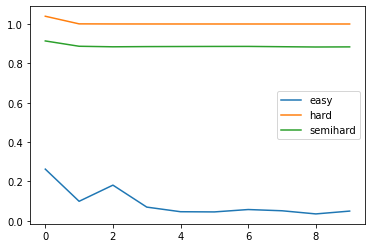

In [26]:
# SOLUTION

model = EmbeddingNet().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 10

for triplet in ["easy", "hard", "semihard"]:
    mining_func = miners.TripletMarginMiner(margin = 0.2, distance=distance, type_of_triplets=triplet)
    loss_evolution = []
    for epoch in range(1, num_epochs + 1):
        loss = train(model, loss_func, mining_func, train_loader, optimizer, epoch)
        loss_evolution.append(loss)
        test(train_dataset, test_dataset, model, accuracy_calculator)
    
    plt.plot(loss_evolution, label=triplet)

plt.legend()
plt.show()

<br>
<span style="color:blue">

**Open Exercise 2**: Read the documentation of the PyTorch Metric Learning library and try a couple of different mining strategies, distances, margins and loss functions.
    
</span>

In [27]:
# Your Code Here


## Better embeddings

<br>
<span style="color:blue">

**Exercise 3**: Train a new (preferably more powerful) network with a 128-dimensional embedding, visualize the embedding using T-SNE. The T-SNE library is installed in the cell below check the sklearn documentation for info on how to use it. Report accuracies for both networks (the one with 2-dimensional embeddings and this one) and compare the visualizations of both embeddings.

Explanation of T-SNE [here](https://distill.pub/2016/misread-tsne/)

**Important T-SNE is rather slow so dont visualize the embeddings for every sample. Randomly select a few**

</span>

In [28]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, n_jobs=2)

In [29]:
# Your Code Here


In [30]:
# SOLUTION

class EmbeddingNet_128(nn.Module):
    def __init__(self):
        super(EmbeddingNet_128, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(9216, 128)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

In [31]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

model = EmbeddingNet_128().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 10

for epoch in range(1, num_epochs + 1):
    train(model, loss_func, mining_func, train_loader, optimizer, epoch)
    test(train_dataset, test_dataset, model, accuracy_calculator)

Epoch 1 Iteration 0: Loss = 0.9000901579856873, Number of mined triplets = 94364
Epoch 1 Iteration 20: Loss = 0.9059590101242065, Number of mined triplets = 17180
Epoch 1 Iteration 40: Loss = 0.8943977355957031, Number of mined triplets = 11332
Epoch 1 Iteration 60: Loss = 0.8984454274177551, Number of mined triplets = 8398
Epoch 1 Iteration 80: Loss = 0.9021268486976624, Number of mined triplets = 10294
Epoch 1 Iteration 100: Loss = 0.8962585926055908, Number of mined triplets = 9756
Epoch 1 Iteration 120: Loss = 0.8992621898651123, Number of mined triplets = 9493
Epoch 1 Iteration 140: Loss = 0.8954777717590332, Number of mined triplets = 7065
Epoch 1 Iteration 160: Loss = 0.8973261117935181, Number of mined triplets = 10200
Epoch 1 Iteration 180: Loss = 0.8975529074668884, Number of mined triplets = 9930
Epoch 1 Iteration 200: Loss = 0.8941258192062378, Number of mined triplets = 8803
Epoch 1 Iteration 220: Loss = 0.8979124426841736, Number of mined triplets = 7056
Epoch 1 Iteration

100%|██████████| 313/313 [00:02<00:00, 140.89it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8572000000000001
Epoch 2 Iteration 0: Loss = 0.8862438201904297, Number of mined triplets = 3884
Epoch 2 Iteration 20: Loss = 0.8944723010063171, Number of mined triplets = 7946
Epoch 2 Iteration 40: Loss = 0.8935779333114624, Number of mined triplets = 6942
Epoch 2 Iteration 60: Loss = 0.8972558975219727, Number of mined triplets = 5773
Epoch 2 Iteration 80: Loss = 0.8903946876525879, Number of mined triplets = 5767
Epoch 2 Iteration 100: Loss = 0.8901824951171875, Number of mined triplets = 4701
Epoch 2 Iteration 120: Loss = 0.8860248327255249, Number of mined triplets = 4718
Epoch 2 Iteration 140: Loss = 0.893086850643158, Number of mined triplets = 6273
Epoch 2 Iteration 160: Loss = 0.8898239135742188, Number of mined triplets = 6899
Epoch 2 Iteration 180: Loss = 0.896257221698761, Number of mined triplets = 10465
Epoch 2 Iteration 200: Loss = 0.8919597864151001, Number of mined triplets = 6255
Epoch 2 Iteration 220: Loss = 0.8

100%|██████████| 313/313 [00:02<00:00, 138.91it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8746
Epoch 3 Iteration 0: Loss = 0.8925666213035583, Number of mined triplets = 4728
Epoch 3 Iteration 20: Loss = 0.8932986855506897, Number of mined triplets = 5003
Epoch 3 Iteration 40: Loss = 0.8937994837760925, Number of mined triplets = 6003
Epoch 3 Iteration 60: Loss = 0.8854361772537231, Number of mined triplets = 2443
Epoch 3 Iteration 80: Loss = 0.8883091807365417, Number of mined triplets = 4185
Epoch 3 Iteration 100: Loss = 0.8921645879745483, Number of mined triplets = 7439
Epoch 3 Iteration 120: Loss = 0.8865965008735657, Number of mined triplets = 2736
Epoch 3 Iteration 140: Loss = 0.8938199281692505, Number of mined triplets = 7899
Epoch 3 Iteration 160: Loss = 0.8936790227890015, Number of mined triplets = 8679
Epoch 3 Iteration 180: Loss = 0.8883869647979736, Number of mined triplets = 3651
Epoch 3 Iteration 200: Loss = 0.8929920792579651, Number of mined triplets = 7051
Epoch 3 Iteration 220: Loss = 0.890345215797

100%|██████████| 313/313 [00:02<00:00, 141.52it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8799
Epoch 4 Iteration 0: Loss = 0.8880525231361389, Number of mined triplets = 3770
Epoch 4 Iteration 20: Loss = 0.8907912969589233, Number of mined triplets = 6291
Epoch 4 Iteration 40: Loss = 0.8914857506752014, Number of mined triplets = 6004
Epoch 4 Iteration 60: Loss = 0.89188152551651, Number of mined triplets = 5773
Epoch 4 Iteration 80: Loss = 0.8906676173210144, Number of mined triplets = 4098
Epoch 4 Iteration 100: Loss = 0.8904318809509277, Number of mined triplets = 7142
Epoch 4 Iteration 120: Loss = 0.8917900919914246, Number of mined triplets = 5636
Epoch 4 Iteration 140: Loss = 0.891304075717926, Number of mined triplets = 5717
Epoch 4 Iteration 160: Loss = 0.8933798670768738, Number of mined triplets = 5726
Epoch 4 Iteration 180: Loss = 0.889985203742981, Number of mined triplets = 4908
Epoch 4 Iteration 200: Loss = 0.8939196467399597, Number of mined triplets = 6232
Epoch 4 Iteration 220: Loss = 0.8897212743759155

100%|██████████| 313/313 [00:02<00:00, 138.53it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8808
Epoch 5 Iteration 0: Loss = 0.888752281665802, Number of mined triplets = 3393
Epoch 5 Iteration 20: Loss = 0.8885257244110107, Number of mined triplets = 3542
Epoch 5 Iteration 40: Loss = 0.8915141820907593, Number of mined triplets = 3631
Epoch 5 Iteration 60: Loss = 0.8873855471611023, Number of mined triplets = 3360
Epoch 5 Iteration 80: Loss = 0.8933383226394653, Number of mined triplets = 5606
Epoch 5 Iteration 100: Loss = 0.8903290033340454, Number of mined triplets = 3402
Epoch 5 Iteration 120: Loss = 0.8934909701347351, Number of mined triplets = 7076
Epoch 5 Iteration 140: Loss = 0.8926613926887512, Number of mined triplets = 6937
Epoch 5 Iteration 160: Loss = 0.8906962871551514, Number of mined triplets = 4855
Epoch 5 Iteration 180: Loss = 0.8916776180267334, Number of mined triplets = 8310
Epoch 5 Iteration 200: Loss = 0.8906636834144592, Number of mined triplets = 5356
Epoch 5 Iteration 220: Loss = 0.8892490863800

100%|██████████| 313/313 [00:02<00:00, 140.28it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8888
Epoch 6 Iteration 0: Loss = 0.8927436470985413, Number of mined triplets = 4939
Epoch 6 Iteration 20: Loss = 0.8859294652938843, Number of mined triplets = 3030
Epoch 6 Iteration 40: Loss = 0.8893953561782837, Number of mined triplets = 3699
Epoch 6 Iteration 60: Loss = 0.8902116417884827, Number of mined triplets = 3340
Epoch 6 Iteration 80: Loss = 0.8915889263153076, Number of mined triplets = 4497
Epoch 6 Iteration 100: Loss = 0.8934457302093506, Number of mined triplets = 4031
Epoch 6 Iteration 120: Loss = 0.893869936466217, Number of mined triplets = 7409
Epoch 6 Iteration 140: Loss = 0.8845533132553101, Number of mined triplets = 1739
Epoch 6 Iteration 160: Loss = 0.8829651474952698, Number of mined triplets = 1832
Epoch 6 Iteration 180: Loss = 0.8929534554481506, Number of mined triplets = 6516
Epoch 6 Iteration 200: Loss = 0.8931533694267273, Number of mined triplets = 7385
Epoch 6 Iteration 220: Loss = 0.8889838457107

100%|██████████| 313/313 [00:02<00:00, 137.60it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8911
Epoch 7 Iteration 0: Loss = 0.8915085792541504, Number of mined triplets = 3869
Epoch 7 Iteration 20: Loss = 0.8908255696296692, Number of mined triplets = 3628
Epoch 7 Iteration 40: Loss = 0.8937917351722717, Number of mined triplets = 4395
Epoch 7 Iteration 60: Loss = 0.8887184858322144, Number of mined triplets = 4412
Epoch 7 Iteration 80: Loss = 0.8894519209861755, Number of mined triplets = 4877
Epoch 7 Iteration 100: Loss = 0.8845160603523254, Number of mined triplets = 2243
Epoch 7 Iteration 120: Loss = 0.890021026134491, Number of mined triplets = 5542
Epoch 7 Iteration 140: Loss = 0.8944193720817566, Number of mined triplets = 4612
Epoch 7 Iteration 160: Loss = 0.8905965089797974, Number of mined triplets = 3506
Epoch 7 Iteration 180: Loss = 0.890170156955719, Number of mined triplets = 4691
Epoch 7 Iteration 200: Loss = 0.8900635242462158, Number of mined triplets = 4754
Epoch 7 Iteration 220: Loss = 0.89206713438034

100%|██████████| 313/313 [00:02<00:00, 139.47it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8909
Epoch 8 Iteration 0: Loss = 0.8903840184211731, Number of mined triplets = 4664
Epoch 8 Iteration 20: Loss = 0.8869088292121887, Number of mined triplets = 3714
Epoch 8 Iteration 40: Loss = 0.8873175382614136, Number of mined triplets = 3341
Epoch 8 Iteration 60: Loss = 0.8851574063301086, Number of mined triplets = 2851
Epoch 8 Iteration 80: Loss = 0.8946951031684875, Number of mined triplets = 2954
Epoch 8 Iteration 100: Loss = 0.8906722068786621, Number of mined triplets = 3774
Epoch 8 Iteration 120: Loss = 0.8932576179504395, Number of mined triplets = 4667
Epoch 8 Iteration 140: Loss = 0.8863535523414612, Number of mined triplets = 4102
Epoch 8 Iteration 160: Loss = 0.8891015648841858, Number of mined triplets = 2787
Epoch 8 Iteration 180: Loss = 0.8907573819160461, Number of mined triplets = 4772
Epoch 8 Iteration 200: Loss = 0.8885216116905212, Number of mined triplets = 4678
Epoch 8 Iteration 220: Loss = 0.891459882259

100%|██████████| 313/313 [00:02<00:00, 140.63it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8936000000000001
Epoch 9 Iteration 0: Loss = 0.8901062607765198, Number of mined triplets = 2916
Epoch 9 Iteration 20: Loss = 0.8910192847251892, Number of mined triplets = 4309
Epoch 9 Iteration 40: Loss = 0.8874114155769348, Number of mined triplets = 3852
Epoch 9 Iteration 60: Loss = 0.8833314180374146, Number of mined triplets = 1902
Epoch 9 Iteration 80: Loss = 0.8834401369094849, Number of mined triplets = 2414
Epoch 9 Iteration 100: Loss = 0.8898264169692993, Number of mined triplets = 6119
Epoch 9 Iteration 120: Loss = 0.8921305537223816, Number of mined triplets = 5955
Epoch 9 Iteration 140: Loss = 0.8912597894668579, Number of mined triplets = 5112
Epoch 9 Iteration 160: Loss = 0.8888702392578125, Number of mined triplets = 4276
Epoch 9 Iteration 180: Loss = 0.8876340985298157, Number of mined triplets = 4077
Epoch 9 Iteration 200: Loss = 0.8919271230697632, Number of mined triplets = 4029
Epoch 9 Iteration 220: Loss = 0.

100%|██████████| 313/313 [00:02<00:00, 138.64it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8934000000000001
Epoch 10 Iteration 0: Loss = 0.886415421962738, Number of mined triplets = 2879
Epoch 10 Iteration 20: Loss = 0.8902180194854736, Number of mined triplets = 5020
Epoch 10 Iteration 40: Loss = 0.8877791166305542, Number of mined triplets = 3699
Epoch 10 Iteration 60: Loss = 0.8915554285049438, Number of mined triplets = 5317
Epoch 10 Iteration 80: Loss = 0.8889772891998291, Number of mined triplets = 2595
Epoch 10 Iteration 100: Loss = 0.8867281079292297, Number of mined triplets = 4369
Epoch 10 Iteration 120: Loss = 0.8851927518844604, Number of mined triplets = 3252
Epoch 10 Iteration 140: Loss = 0.8872384428977966, Number of mined triplets = 4181
Epoch 10 Iteration 160: Loss = 0.8893359303474426, Number of mined triplets = 4069
Epoch 10 Iteration 180: Loss = 0.8911575675010681, Number of mined triplets = 5412
Epoch 10 Iteration 200: Loss = 0.8922393918037415, Number of mined triplets = 4228
Epoch 10 Iteration 220

100%|██████████| 313/313 [00:02<00:00, 139.45it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8972


100%|██████████| 1875/1875 [00:12<00:00, 145.63it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.106s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 0.748570
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.613899
[t-SNE] KL divergence after 900 iterations: 0.069769


100%|██████████| 313/313 [00:02<00:00, 142.36it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.104s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.749693
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.008739
[t-SNE] KL divergence after 1000 iterations: 0.070192


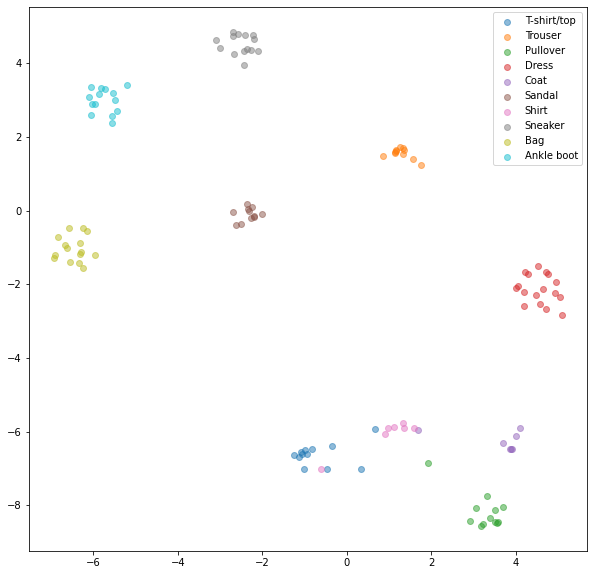

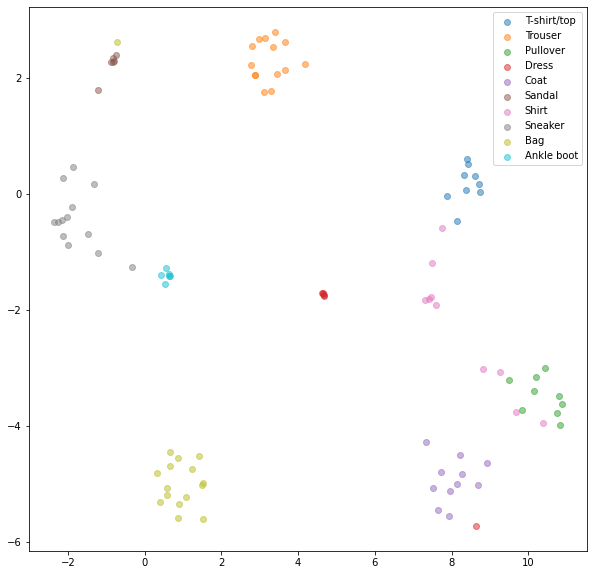

In [32]:
train_embeddings, train_labels = get_all_embeddings(train_dataset, model)

train_embeddings = tsne.fit_transform(train_embeddings[::500].cpu())

plot_embeddings(train_embeddings, train_labels[::500].cpu())
val_embeddings_baseline, val_labels_baseline = get_all_embeddings(test_dataset, model)
val_embeddings_baseline = tsne.fit_transform(val_embeddings_baseline[::100].cpu())

plot_embeddings(val_embeddings_baseline, val_labels_baseline[::100].cpu())